## HW 5 Assignment 1

#### Code is taken primarily from Sebastian Bana's notebook, as well as my own HW4.

In [1]:
from __future__ import print_function
import pylab as pl
import pandas as pd
import numpy as np
import os
import scipy.stats as st

%pylab inline

np.random.seed(345)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    ### First I will heck that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

In [3]:
datestring='201501'
getCitiBikeCSV('201501')

file in place, you can continue


In [4]:
# Load the data
df = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')

#Using Fedhere's age and gender data organization
df['age'] = 2015 - df['birth year'][(df['usertype'] == 'Subscriber')]

#only need age
df = df[['age']].copy()
# dropping NaN values
df['age'].dropna(inplace= True)

print (len(df))
print (df.age.mean())
print (df.age.std())
df.head()

285552
40.0485810434
11.5746367124


,age
0,55.0
1,52.0
2,41.0
3,46.0
4,38.0


In [5]:
#create bins for the ages
bins = np.arange(15, 99, 5)

#Generate the cummulative distributions for age 
#http://www.itl.nist.gov/div898/handbook/eda/section3/eda35f.htm
#The group by along with the cumsim will get the cumulative count for each of the bins
cs=df.age.groupby(pd.cut(df.age, bins)).agg([count_nonzero]).cumsum()

In [6]:
cs.head(), cs.tail()

(          count_nonzero
 age                    
 (15, 20]         2474.0
 (20, 25]        21550.0
 (25, 30]        68104.0
 (30, 35]       117262.0
 (35, 40]       155894.0,           count_nonzero
 age                    
 (70, 75]       279507.0
 (75, 80]       279728.0
 (80, 85]       279782.0
 (85, 90]       279786.0
 (90, 95]       279803.0)

### Gaussian distribution

In [7]:
# Generate a gaussian distribution with the same number of samples, mean, and standard deviation as the citibike df 
dfNorm = pd.DataFrame(data=np.random.normal(40.0485810434,11.5746367124,size=279803))

In [8]:
# Bin the Gaussian distribution because the chi-square goodness of fit test is for binned data
csSampleNorm=dfNorm[0].groupby(pd.cut(dfNorm[0], bins)).agg([count_nonzero]).cumsum()

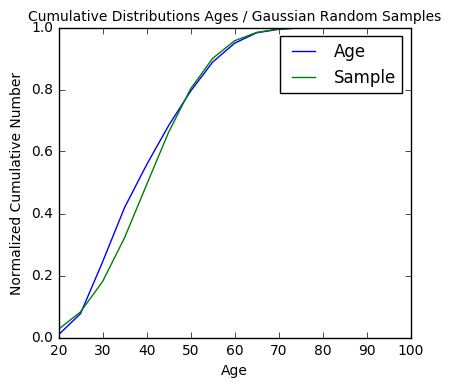

In [9]:
pl.figure(figsize=(10, 4))
pl.subplot(121)
pl.title('Cumulative Distributions Ages / Gaussian Random Samples',fontsize = 10)
pl.plot(bins[:-1] + 5, cs / cs.max(), label = "Age")
pl.plot(bins[:-1] + 5, csSampleNorm / csSampleNorm.max(), label = "Sample")
pl.xlabel("Age")
pl.ylabel("Normalized Cumulative Number")
pl.legend()

### Poisson distribution

In [10]:
# Generate a poisson distribution with the same number of samples and mean as the citibike df
dfPoiss = pd.DataFrame(data=np.random.poisson(40,size=279803))
 
csSamplePoiss=dfPoiss[0].groupby(pd.cut(dfPoiss[0], bins)).agg([count_nonzero]).cumsum()

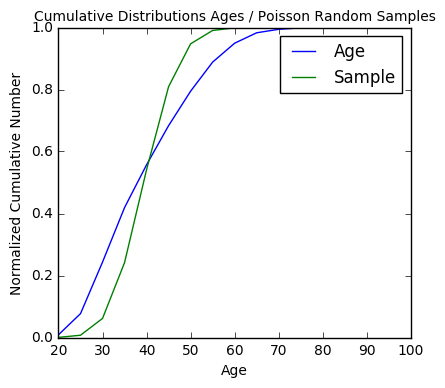

In [11]:
pl.figure(figsize=(10, 4))
pl.subplot(122)
pl.title('Cumulative Distributions Ages / Poisson Random Samples',fontsize = 10)
pl.plot(bins[:-1] + 5, cs / cs.max(), label = "Age")
pl.plot(bins[:-1] + 5, csSamplePoiss / csSamplePoiss.max(), label = "Sample")
pl.xlabel("Age")
pl.ylabel("Normalized Cumulative Number")
pl.legend()

#####  As you can see ffrom the two plots, the curve of the Citibike data (Age) follows the curve of the Gaussian samples much more closely than the curve of the Poisson samples

### Chi-square Goodness of Fit Test

    Null Hypothesis 1: The ages of CitiBike subscribers are normally distributed.
    Alternative Hypothesis 1: The ages of CitiBike subscribers are not normally distributed.
    
    Null Hypothesis 2: The ages of CitiBike subscribers follow a Poisson distribution.
    Alternative Hypothesis 2: The ages of CitiBike subscribers do not follow a Poisson distribution.

In [12]:
# Chi-square test requires observed and expected values. In this case, observed will be the ages from Citibike data
# Expected will be the Gaussian and Poisson samples
f_exp_norm = dfNorm[0].groupby(pd.cut(dfNorm[0], bins)).agg([count_nonzero])
f_exp_poiss = dfPoiss[0].groupby(pd.cut(dfPoiss[0], bins)).agg([count_nonzero])
f_obs = df.age.groupby(pd.cut(df.age, bins)).agg([count_nonzero])

In [13]:
# Calculate the Chi-square statistic
chisqstatNorm=st.chisquare(f_obs=f_obs.count_nonzero, f_exp=f_exp_norm.count_nonzero, ddof=14)
chisqstatPoiss=st.chisquare(f_obs=f_obs.count_nonzero, f_exp=f_exp_poiss.count_nonzero)
print ('The chisq for Normal Distribution is: ', chisqstatNorm)
print ('The chisq for Poisson Distribution is: ', chisqstatPoiss)

The chisq for Normal Distribution is:  Power_divergenceResult(statistic=27735.339470373827, pvalue=0.0)
The chisq for Poisson Distribution is:  Power_divergenceResult(statistic=inf, pvalue=0.0)


#### Our degrees of freedom is 15 (n-1, i.e. 16 bins minus 1), and alpha is 0.05. With these parameters, the critical chi-square statistic is 24.996. The chi-square value we obtained using both the normal distribution (27735) and the Poisson distribution (inf) are significantly higher than this critical value. As such, we must reject both null hypotheses.

### Anderson-Darling Test

In [14]:
# We used the NIST stats handbook as a reference  http://www.itl.nist.gov/div898/handbook/eda/section3/eda35e.htm

# http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson_ksamp.html
# We choose the python scipy.stats.anderson_ksamp rather than the regular scipy.stats.anderson
# In order to use the same samples that we created (rather than simply specifying the function the distirbuion name)

#Had to take a subsets of the samples

andersonNorm = st.anderson_ksamp([df.age[0:10000],dfNorm[0][0:10000]])
andersonPoiss = st.anderson_ksamp([df.age[0:1000],dfPoiss[0][0:1000]])

print ('The k-sample AD statistic for Normal Distribution is: ', andersonNorm)
print ('The k-sample AD statistic for Poisson Distribution is: ', andersonPoiss)

The k-sample AD statistic for Normal Distribution is:  Anderson_ksampResult(statistic=106.29499158437639, critical_values=array([ 0.325,  1.226,  1.961,  2.718,  3.752]), significance_level=4.400485414381441e+75)
The k-sample AD statistic for Poisson Distribution is:  Anderson_ksampResult(statistic=111.17712597749413, critical_values=array([ 0.325,  1.226,  1.961,  2.718,  3.752]), significance_level=1.2637783526420292e+85)


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/scipy/stats/morestats.py:1685: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


#### We are interested in the critical value at a significance level of 5%, which is 1.961. The test statistics we get using either the Normal distribution (106) or the Poison distribution (111) are significantly higher than this critical value. Therefore, we reject both null hypotheses.